In [249]:
import torch.optim as optim
import torch
import numpy as np
import matplotlib.pyplot as plt
%run NNs.ipynb
%run helpers_preproc.ipynb
#added test

In [250]:
#read in the data, get normalized adjacency (NxN)
mesh_dir = 'SHREC11/'
label_np = np.array(readLbl(mesh_dir+'labels.txt'))

In [252]:
node_sigs_list = []
normed_adjMats_list = []

for i in range(600):
    fName = 'T' + str(i) + '.obj'
    adj_noscale_read = obj_2_adj_noscale(mesh_dir + fName)
    adj_scaled_read = obj_2_adj(mesh_dir + fName)

    if (adj_scaled_read.shape[0] < 252):
        adj_noscale = np.empty([252,252])
        adj_scaled = np.empty([252,252])
    else:
        adj_noscale = adj_noscale_read
        adj_scaled = adj_scaled_read

    adj_normalized = adj_noscale / np.reshape(np.sum(adj_noscale,axis = 1),[adj_noscale.shape[0],1])

    #node level signal extraction
    node_degs = np.sum(adj_noscale,axis = 0)
    node_neigh_max = np.max(adj_scaled,axis = 0)
    node_neigh_min = np.min(adj_scaled,axis = 0)
    node_neigh_sum = np.sum(adj_scaled,axis = 0)
    node_neigh_mean = np.sum(adj_scaled,axis = 0)

    node_sig = np.stack([node_degs,node_neigh_max,node_neigh_min,node_neigh_sum,node_neigh_mean],axis = 1)
    
    node_sigs_list.append(node_sig)
    normed_adjMats_list.append(adj_normalized)

In [253]:
normed_adjMats = np.nan_to_num(np.stack(normed_adjMats_list))
node_sigs = np.nan_to_num(np.stack(node_sigs_list))

In [254]:
normed_adjMats_tr = normed_adjMats[:450,:,:]
node_sigs_tr = node_sigs[:450,:,:]
label_np_tr = label_np[:450]

normed_adjMats_ts = normed_adjMats[450:,:,:]
node_sigs_ts = node_sigs[450:,:,:]
label_np_ts = label_np[450:]

label_mat_tr = torch.tensor(np.where(igl.all_pairs_distances(label_np_tr,label_np_tr,False) > 0.5,0,1)).float()
label_mat_ts = torch.tensor(np.where(igl.all_pairs_distances(label_np_ts,label_np_ts,False) > 0.5,0,1)).float()

In [255]:
normed_adjMats_tr = torch.tensor(normed_adjMats_tr).float()
node_sigs_tr = torch.tensor(node_sigs_tr).float()
label_np_tr = torch.tensor(label_np_tr).float()

normed_adjMats_ts = torch.tensor(normed_adjMats_ts).float()
node_sigs_ts = torch.tensor(node_sigs_ts).float()
label_np_ts = torch.tensor(label_np_ts).float()

In [256]:
#label_mat_train = form_label_matrix(label_mat, train_dict)

In [257]:
#normed_adjMats_list_train, node_sigs_list_train = prep_data(train_dict)

In [258]:
#normed_adjMats_train = np.stack(normed_adjMats_list_train)
#node_sigs_train = np.stack(node_sigs_list_train)

#normed_adjMats_train = torch.tensor(normed_adjMats_train,requires_grad=False).float()
#node_sigs_train = torch.tensor(node_sigs_train,requires_grad=False).float()

#normed_adjMats_train = torch.nan_to_num(normed_adjMats_train,0,0,0)
#node_sigs_train = torch.nan_to_num(node_sigs_train,0,0,0)

In [259]:
node_sigs_tr

tensor([[[5.0000, 0.0888, 0.0000, 0.3595, 0.3595],
         [7.0000, 0.1017, 0.0000, 0.4655, 0.4655],
         [6.0000, 0.0920, 0.0000, 0.4395, 0.4395],
         ...,
         [7.0000, 0.1142, 0.0000, 0.5429, 0.5429],
         [6.0000, 0.1352, 0.0000, 0.4959, 0.4959],
         [7.0000, 0.1352, 0.0000, 0.5233, 0.5233]],

        [[5.0000, 0.1061, 0.0000, 0.4014, 0.4014],
         [5.0000, 0.1546, 0.0000, 0.4404, 0.4404],
         [5.0000, 0.2171, 0.0000, 0.5315, 0.5315],
         ...,
         [5.0000, 0.1340, 0.0000, 0.4817, 0.4817],
         [6.0000, 0.1705, 0.0000, 0.7666, 0.7666],
         [5.0000, 0.1284, 0.0000, 0.4872, 0.4872]],

        [[4.0000, 0.1228, 0.0000, 0.3313, 0.3313],
         [5.0000, 0.2132, 0.0000, 0.5203, 0.5203],
         [4.0000, 0.1201, 0.0000, 0.2880, 0.2880],
         ...,
         [5.0000, 0.1041, 0.0000, 0.4604, 0.4604],
         [5.0000, 0.1094, 0.0000, 0.4256, 0.4256],
         [4.0000, 0.0913, 0.0000, 0.3470, 0.3470]],

        ...,

        [[7.0000, 0.

In [260]:
g = GCN(5,[5,5,5,5])
n = MLP(252*5,[5,5,5,5])
output1 = g.forward(normed_adjMats_tr,node_sigs_tr)
output2 = n.forward(output1)
print(output1.shape)
print(output2.shape)

torch.Size([450, 252, 5])
torch.Size([450, 5])


In [261]:
def lossF(features,lbl_mat):
    disMat = torch.cdist(features,features)
    sameType = disMat * (lbl_mat-torch.diag(torch.ones(lbl_mat.shape[0])))
    diffType = disMat * (1-lbl_mat)

    diffTypeScaled = diffType * torch.exp(-diffType)
    diffTypeScaledMean = torch.sum(diffTypeScaled)/ torch.count_nonzero(diffTypeScaled)
    diffTypeMean = torch.sum(diffType)/ torch.count_nonzero(diffType)

    sameTypeMean = torch.sum(sameType) / torch.count_nonzero(sameType)
    sameTypeStd = torch.sum((sameType - sameTypeMean)**2) / torch.count_nonzero(sameType)

    print(sameTypeMean.detach().numpy(),diffTypeMean.detach().numpy(),torch.sqrt(sameTypeStd).detach().numpy())
    return  sameTypeMean-diffTypeScaledMean + 0.01 * torch.sqrt(sameTypeStd)

In [ ]:
optimizer = optim.Adam(g.weights + n.weights,lr = 0.0001)
for i in range(100000):
    optimizer.zero_grad()
    output = n.forward(g.forward(normed_adjMats_tr,node_sigs_tr))
    loss = lossF(output,label_mat_tr)
    loss.backward()
    optimizer.step()

0.122026354 0.12100363 0.6795335
0.12012935 0.12114708 0.6690786
0.11709165 0.11674342 0.6523543
0.11032217 0.11027447 0.61512554
0.118472695 0.11683347 0.66016036
0.1105344 0.11134019 0.6160788
0.10633195 0.106847 0.5925501
0.11603182 0.11463371 0.6462106
0.107973054 0.10671262 0.6012928
0.10087748 0.101109155 0.5617361
0.1051587 0.10487291 0.5864099
0.10461259 0.1047289 0.58346707
0.103097185 0.103022136 0.5748715
0.10454534 0.10451049 0.5829937
0.10237906 0.103236124 0.57040846
0.099608116 0.09917291 0.5548918
0.099077456 0.09857692 0.5518016
0.09740916 0.097018614 0.54257107
0.091963686 0.09283416 0.51266986
0.09762324 0.09687272 0.544563
0.094622515 0.09462774 0.52713156
0.0950146 0.09449768 0.5298191
0.087480076 0.08772004 0.48761824
0.09208669 0.09102342 0.5130531
0.08941617 0.09108342 0.4985117
0.08605008 0.087550364 0.4796669
0.0931214 0.093430035 0.519402
0.08586013 0.085062675 0.47888452
0.08229353 0.082748055 0.45880738
0.082513735 0.08207099 0.46056426
0.07935802 0.0796063

0.011598219 0.011512266 0.07651807
0.011556764 0.011417423 0.07600533
0.0114224795 0.011361044 0.075532824
0.010624569 0.010506907 0.071636096
0.011839991 0.011553735 0.077827625
0.0109392535 0.010934658 0.07311884
0.011092678 0.01072438 0.07401724
0.009807194 0.009682489 0.06742564
0.010627752 0.010445905 0.07166406
0.010607063 0.010421276 0.07153284
0.010181507 0.010075375 0.06937555
0.011030697 0.011136794 0.07380103
0.010358027 0.010388874 0.07027328
0.0113770105 0.011233573 0.0752648
0.010274723 0.010101018 0.06864176
0.011154145 0.010996741 0.074369304
0.01094479 0.010769233 0.07316799
0.009912558 0.009780308 0.06817881
0.009690534 0.009499843 0.06693191
0.010666609 0.010501996 0.07197166
0.010612199 0.01036451 0.07150275
0.010209811 0.010220823 0.070603356
0.010858321 0.010850676 0.07237612
0.01013533 0.01003739 0.06922854
0.010580395 0.010495155 0.071959846
0.00975828 0.009659978 0.06712414
0.010030592 0.009915501 0.06851484
0.009615462 0.009615726 0.06701335
0.011322284 0.0112

0.0056397375 0.005576648 0.045563318
0.005346239 0.0052487967 0.044531297
0.0054313317 0.005300153 0.044928774
0.005557164 0.005418996 0.04544199
0.0054817353 0.0053848815 0.045096353
0.0054946286 0.0053966506 0.044457212
0.006267644 0.0060758153 0.04843518
0.0056721033 0.0055165025 0.045834493
0.0052453564 0.0051757377 0.044116788
0.0055357213 0.005409196 0.045107007
0.0053945263 0.0052502817 0.04451168
0.005608225 0.005520189 0.045435537
0.005845091 0.0057310155 0.0460543
0.005682178 0.005580132 0.045758367
0.0057121413 0.0055639427 0.045571096
0.0054396926 0.0052905404 0.04467793
0.0053947796 0.005287284 0.04445537
0.0058062635 0.0056800023 0.046017054
0.005632016 0.0054272334 0.04535558
0.0055992245 0.005496231 0.045573507
0.0050481874 0.0049485485 0.043089394
0.0050965995 0.0050256043 0.04294651
0.0050027254 0.004938372 0.04287209
0.0052913236 0.005232894 0.043932393
0.0052647563 0.005080826 0.043802753
0.0052625714 0.0051588486 0.043753322
0.0050629633 0.004914987 0.04279613
0.00

0.0037336368 0.0036464417 0.03330984
0.003608743 0.0035144165 0.03263917
0.0035611917 0.0034203113 0.032388825
0.003645426 0.0035706507 0.03289357
0.0032046067 0.003138312 0.031330556
0.0035748992 0.0034834929 0.032542102
0.0035648618 0.0034664467 0.032471947
0.003680368 0.0035998244 0.032859575
0.0033350294 0.0032488876 0.0316258
0.003639857 0.0036083427 0.032840926
0.0035858965 0.0034666357 0.03243519
0.0032068675 0.0031047652 0.03107145
0.003502465 0.0034170046 0.032051332
0.0033270088 0.003251751 0.031503357
0.0036359937 0.0035559074 0.032541446
0.0034738304 0.0034160619 0.03201773
0.003777151 0.0035628385 0.033202745
0.0035388207 0.0034520435 0.032090444
0.0033845776 0.00331634 0.0316275
0.0034348075 0.0033366664 0.031737216
0.0035096935 0.0033964743 0.03158976
0.0039652637 0.0038780165 0.033638794
0.003146737 0.0030666515 0.030584933
0.0033050443 0.0032015757 0.030903505
0.003368992 0.0032737262 0.031394657
0.0032867622 0.0032062165 0.031035842
0.0032519982 0.0031535884 0.0309071

0.0028549035 0.0027325233 0.025086094
0.0026235844 0.0025229813 0.024026444
0.002905045 0.0029058917 0.02540233
0.0023048776 0.0022154143 0.023122653
0.0025420375 0.0024752328 0.023759836
0.002347476 0.002269275 0.023092039
0.0022945125 0.0022497158 0.022923708
0.002451003 0.0024169348 0.023330836
0.0027732702 0.002719306 0.025045577
0.002302435 0.002228881 0.022906246
0.002419967 0.0023315467 0.023218662
0.0023110947 0.0022462548 0.022880752
0.0024686507 0.0024349086 0.023351992
0.002573286 0.0024962807 0.023653843
0.0023112153 0.002230537 0.022800159
0.0024704544 0.0024037275 0.023103455
0.0024932611 0.0024331298 0.023533044
0.002341293 0.002262775 0.021645062
0.0025921157 0.002514109 0.023654718
0.0026973798 0.002620425 0.024175141
0.0024185523 0.002363663 0.021881409
0.0025607774 0.0024868587 0.023430867
0.0021517184 0.002086598 0.02209906
0.002261701 0.0021889494 0.022461126
0.0024808794 0.0024179013 0.023301268
0.002366444 0.002276401 0.022707224
0.0024123155 0.002353308 0.022910

0.0016968072 0.001635047 0.016428394
0.0018335071 0.0017699174 0.016917875
0.0017728353 0.001728043 0.01668232
0.0016865544 0.0016372605 0.01630454
0.0015776115 0.0015314078 0.01598202
0.0017955855 0.0017492026 0.016683735
0.0019042986 0.0018363037 0.017434202
0.0019544177 0.0019120044 0.017331686
0.0019138793 0.0018379753 0.017008599
0.0016315674 0.0015892725 0.016005311
0.0018470124 0.0018231338 0.016768254
0.0018474758 0.0018105763 0.01678902
0.0017545386 0.001689866 0.016381044
0.0016618371 0.0016108698 0.016059522
0.0018621854 0.0017833315 0.016742721
0.0015739151 0.0015114369 0.01571577
0.0017034946 0.0016564305 0.016063707
0.0017205541 0.0016524184 0.016220422
0.0016527523 0.0015954945 0.015948653
0.0016166285 0.0015936918 0.015790885
0.0019104945 0.0018409708 0.016840458
0.0018565254 0.0018030023 0.016746372
0.0017816649 0.0017321826 0.016381253
0.0016650001 0.0016286249 0.015600643
0.0015639346 0.0015238991 0.015518516
0.0016096326 0.0015766878 0.015671387
0.0015578782 0.00152

0.0011413287 0.0011137422 0.01089035
0.0012292407 0.001197192 0.011684461
0.0011986556 0.0011618221 0.010859178
0.0012839166 0.0012614871 0.011146241
0.0014684234 0.0014451144 0.01200781
0.0012264213 0.0011982694 0.010929435
0.00116146 0.0011470412 0.010822732
0.0012762826 0.0012393257 0.011146505
0.0011173557 0.00108697 0.01049006
0.0012738974 0.0012401276 0.011105663
0.0012054181 0.0011835202 0.0107307155
0.0010709001 0.0010436487 0.01028213
0.0011519289 0.0011120334 0.010511949
0.001037549 0.001023575 0.010104099
0.0012406213 0.0012029822 0.010760443
0.0010178715 0.0010028357 0.009984977
0.0012949292 0.0012701371 0.011264619
0.0010672932 0.0010350371 0.010193401
0.0010417314 0.0010046591 0.010058842
0.0012253916 0.0011828701 0.010676183
0.001068717 0.0010575952 0.010142886
0.0011475742 0.0010919854 0.0104371095
0.001159248 0.0011250975 0.010416332
0.001047093 0.0010226413 0.010005044
0.0010972382 0.0010694971 0.010142618
0.001086953 0.0010479027 0.010096097
0.0011362082 0.0011130553

0.000711165 0.0006908979 0.0061823768
0.0007220263 0.0007053237 0.006218522
0.0007172437 0.0007103247 0.0062049325
0.00070952816 0.0006955019 0.006157628
0.0008413139 0.0008215516 0.006707545
0.00079176505 0.000777198 0.0064603663
0.0007330399 0.00071640057 0.0062363753
0.0007033309 0.00067683525 0.006080606
0.00076782244 0.00076432107 0.0063525345
0.0009888936 0.0009321639 0.007776735
0.0007490696 0.00073360297 0.006254149
0.0007156751 0.00069791987 0.0060669016
0.0008018292 0.00079408684 0.0064076185
0.0006367403 0.00062406133 0.00576442
0.00067357183 0.0006483719 0.005880115
0.00085507764 0.00085563044 0.0069837
0.0007827112 0.0007669216 0.0062614586
0.00068676396 0.00066546054 0.0059136786
0.0008053255 0.00080690027 0.0063942755
0.00073344854 0.0007129138 0.0061427895
0.00065009884 0.0006293085 0.0057259663
0.0007275007 0.0007179812 0.006019072
0.00079902547 0.00076988834 0.006348011
0.00072376814 0.0007060001 0.0059984503
0.0008245298 0.0008006239 0.0064225392
0.00073149556 0.0007

0.0004054476 0.00040099 0.0030251665
0.00051474926 0.00050931575 0.0035454636
0.00043450567 0.00042841237 0.0031360458
0.00048706075 0.0004818924 0.0034181955
0.00047023312 0.0004662989 0.0033300072
0.00045065483 0.00044257147 0.0031889414
0.0004556453 0.00044596344 0.003222902
0.0004495369 0.00043801547 0.0031886094
0.00043045988 0.00042554273 0.0030824712
0.00068724767 0.00063133286 0.005430729
0.00040794912 0.0004038443 0.002985567
0.00043164837 0.00041752364 0.0030316934
0.00045047927 0.00044468234 0.0032300737
0.0004946469 0.0004903396 0.0033867755
0.00039637712 0.00038683348 0.0028847274
0.00046810173 0.00046143756 0.0032365008
0.00042877847 0.00043322291 0.0030722164
0.00044784925 0.0004582983 0.00318144
0.0004971852 0.00048337018 0.0034135208
0.00043161536 0.000417629 0.0030862447
0.00044608396 0.0004344905 0.003100365
0.00045370907 0.00043901656 0.0031365748
0.0005207028 0.0005198237 0.003506552
0.00043017397 0.00041715306 0.003010268
0.00049199484 0.0004909024 0.0033055712
0.

0.0002998655 0.00029077946 0.0018283727
0.0002187656 0.00021742668 0.0013757028
0.00027184264 0.00026938424 0.0016669197
0.00038822368 0.00039622738 0.0024914257
0.00025938393 0.00025587346 0.0015994818
0.00027960748 0.0002810502 0.0017415583
0.0002919978 0.000292899 0.0018111232
0.00028454076 0.00028437102 0.0017537831
0.00031252974 0.00031977764 0.0018966005
0.00032925696 0.00032690744 0.0020441837
0.00023580421 0.00023343237 0.0014597517
0.0002812273 0.00027599253 0.0017254619
0.00025353907 0.00025917048 0.0015753895
0.00039788423 0.00040060218 0.0033575257
0.00031750044 0.00031390588 0.0019594857
0.0002557823 0.0002547268 0.0015821585
0.00027254262 0.00027606596 0.0016771613
0.00024795052 0.00024473626 0.0015164756
0.00025117357 0.0002581123 0.001552789
0.0002865268 0.0002801911 0.0017291805
0.00025777487 0.00026016127 0.0015999221
0.00035966648 0.0003814538 0.0025292558
0.00028683452 0.00028804172 0.0017538166
0.00031457315 0.00031451383 0.001964469
0.0002679723 0.0002602138 0.001

0.00018362378 0.00018907175 0.001080637
0.00013370089 0.00013515072 0.0007801065
0.00015721635 0.00015653035 0.0009111845
0.00018683424 0.00018704853 0.0010725232
0.0001979085 0.00019335875 0.0011675986
0.00019774129 0.00020443134 0.0012099149
0.00020951145 0.00020437269 0.0012446723
0.00018515991 0.00018285979 0.0010832819
0.00021843948 0.00020744579 0.0014501364
0.0002161841 0.00021008591 0.0013026883
0.00020980996 0.00020386805 0.0012718767
0.00022920711 0.00022266089 0.0014364468
0.00017558044 0.00017869684 0.0010563694
0.00016439341 0.00016661495 0.0009831554
0.00016861864 0.0001703545 0.0009967705
0.00017822704 0.00017894975 0.0010407008
0.0002198856 0.00022239749 0.00145409
0.00020504573 0.00020925158 0.0011984248
0.00017580751 0.0001712902 0.001021621
0.00020101524 0.00019748081 0.0012040508
0.0001624931 0.00015966038 0.0009587957
0.00027170626 0.00027452133 0.0018418673
0.00013806447 0.00013840603 0.00079806364
0.00039862117 0.0003734113 0.0035702758
0.000178846 0.00017826655 

0.00012035177 0.00012155053 0.00069853954
0.000107608714 0.000108888285 0.0006168673
0.00012994642 0.00013019568 0.0007565479
0.00013090472 0.00013121891 0.0007828544
0.00015124773 0.0001477034 0.0009553473
0.00012750528 0.0001267046 0.0007537102
0.0001549453 0.00015129983 0.00092050544
0.000117779644 0.00011867588 0.00069147313
0.00018064321 0.00017974804 0.0010956019
0.00013480693 0.00013493517 0.0007885145
0.00013023287 0.00012838145 0.00075186294
0.00014953686 0.00015873587 0.0009305043
0.00012144412 0.0001194173 0.0006994474
0.000121145145 0.00011790886 0.0007008281
0.00012914732 0.00012930596 0.0007625542
0.0001331271 0.00013218245 0.0008049933
0.000109823945 0.00010931144 0.0006515849
0.00012747235 0.00013290747 0.0007892396
0.00010371924 0.000105987885 0.0006009202
0.00011452251 0.00011671977 0.00066134025
0.00010227865 0.00010089544 0.000591642
0.00010808143 0.000109081266 0.0006350459
0.00014917032 0.00014680902 0.000898897
0.0001659502 0.00016374675 0.0009984873
0.0001429233

0.00010423228 0.00010432863 0.0006168669
0.00011296139 0.00011345546 0.0006798982
0.00010477405 0.0001051852 0.0006457239
9.161344e-05 9.377265e-05 0.0005485065
9.7503245e-05 9.695609e-05 0.00056178874
0.000105357896 0.000106407744 0.00061929383
0.00011998295 0.00011513578 0.0007245297
0.00010082362 9.8868244e-05 0.0005922468
0.00011098482 0.000112274654 0.0006785742
0.00017808742 0.00017737613 0.001200866
9.391398e-05 9.216871e-05 0.0005522951
7.6592565e-05 7.840644e-05 0.0004396911
8.2330545e-05 8.372219e-05 0.00047168558
0.0001214374 0.00012175298 0.0007333054
9.090607e-05 9.0544054e-05 0.0005199299
0.00017287133 0.00016316323 0.0012749039
0.00011641908 0.00011413235 0.0007163863
0.00012050087 0.000119771 0.0007380368
0.000107367516 0.00010706933 0.0006296026
8.477062e-05 8.433036e-05 0.0005034173
8.1861595e-05 8.195123e-05 0.0004720719
8.018351e-05 8.093326e-05 0.00045923376
0.0001310662 0.00012476802 0.0009334464
0.000109091816 0.000110471905 0.00064574176
8.922517e-05 8.8700035e-

6.967857e-05 7.065278e-05 0.00040313174
9.9355784e-05 9.927417e-05 0.00058377435
7.020504e-05 7.035268e-05 0.0004089424
7.884506e-05 7.9329286e-05 0.0004670792
0.0001333986 0.00012783293 0.0009021242
7.8663455e-05 7.665999e-05 0.0004592098
7.927065e-05 8.1239064e-05 0.00047383725
9.747259e-05 9.681356e-05 0.0005868539
7.241457e-05 7.2439034e-05 0.0004301396
8.028672e-05 8.185789e-05 0.00047712235
9.478669e-05 9.714148e-05 0.0005771784
8.430416e-05 8.6218155e-05 0.00049676513
8.707798e-05 8.6326014e-05 0.0005173438
0.0001169855 0.00011950066 0.0007281093
7.019409e-05 7.2378425e-05 0.00041088418
8.495386e-05 8.62856e-05 0.00051104475
6.962788e-05 6.7856505e-05 0.00039935132
9.838845e-05 0.00010069921 0.0006050744
0.00011714021 0.00012293582 0.0007272997
0.00010458369 0.000102381186 0.0006716929
0.00011024106 0.00010543932 0.00067852734
8.2924715e-05 8.485002e-05 0.00050681125
9.6624484e-05 9.944509e-05 0.00062729063
0.00012546626 0.00012660444 0.0007791687
0.0001243672 0.00012125084 0.00

5.858608e-05 5.6068224e-05 0.00035220373
8.8461886e-05 9.082629e-05 0.0005700568
5.896456e-05 5.8581943e-05 0.0003407323
8.008146e-05 7.857178e-05 0.0004934614
5.8724807e-05 6.004671e-05 0.00034294312
5.3750024e-05 5.338346e-05 0.0003170659
6.449874e-05 6.324574e-05 0.00038562797
0.00011134914 0.00010669918 0.0007670795
6.129977e-05 6.0332364e-05 0.000365188
7.075368e-05 7.163669e-05 0.0004307885
7.0887974e-05 7.117157e-05 0.0004310599
7.728934e-05 7.750029e-05 0.00048867764
0.00014375478 0.00013421137 0.0012332174
5.941647e-05 5.8606634e-05 0.0003464882
6.524343e-05 6.3532825e-05 0.000384205
6.865897e-05 6.807628e-05 0.00041095584
7.222113e-05 7.2495175e-05 0.00045424083
7.9213474e-05 7.80356e-05 0.0005180779
8.9537694e-05 8.7502216e-05 0.0005428118
5.89645e-05 6.103352e-05 0.00035285126
8.225125e-05 8.265992e-05 0.0005689346
6.441238e-05 6.277715e-05 0.0003789975
6.1145496e-05 6.0743627e-05 0.00036591978
5.8595873e-05 5.7188467e-05 0.00033885078
0.00010135061 9.996974e-05 0.000713434

4.6193847e-05 4.4929187e-05 0.00026649414
5.034017e-05 4.9934544e-05 0.0003068068
6.486508e-05 6.5102024e-05 0.00038747993
5.234726e-05 5.24777e-05 0.00031522295
6.933152e-05 6.825199e-05 0.0004180286
6.0325307e-05 6.094575e-05 0.00035806495
5.386965e-05 5.2205127e-05 0.00032667237
6.0012964e-05 6.0503844e-05 0.00037080722
4.163215e-05 4.2449967e-05 0.00024781178
8.406545e-05 8.670727e-05 0.00069434434
6.690589e-05 6.9689515e-05 0.000467363
5.3679425e-05 5.2976487e-05 0.0003311614
5.1858653e-05 5.159082e-05 0.00030529514
6.460681e-05 6.3132975e-05 0.0004347651
5.2337982e-05 5.306628e-05 0.0003221438
4.240931e-05 4.3540687e-05 0.00024623272
6.492909e-05 6.356181e-05 0.00039611504
5.9260976e-05 5.900949e-05 0.0003542867
4.8099755e-05 4.6974877e-05 0.00027668723
5.6529694e-05 5.7554884e-05 0.00033584354
5.9834492e-05 6.05567e-05 0.00035504776
7.125391e-05 6.936551e-05 0.00043295618
5.1878364e-05 5.0948398e-05 0.00030162826
4.734044e-05 4.7532263e-05 0.0002743296
5.2697895e-05 5.3684227e-0

5.812338e-05 5.7678335e-05 0.0004171102
4.6420086e-05 4.645194e-05 0.0002774739
8.514273e-05 8.289597e-05 0.00078313635
6.531438e-05 6.3970634e-05 0.00046795464
3.9333554e-05 3.8158363e-05 0.00022445117
4.524425e-05 4.505686e-05 0.00031028653
3.5539706e-05 3.5984383e-05 0.00021306495
4.417543e-05 4.4412176e-05 0.00026275375
4.7189133e-05 4.6858757e-05 0.00029412715
4.7877937e-05 4.776015e-05 0.00028318824
3.8738173e-05 4.0100702e-05 0.00022848147
4.444153e-05 4.4402364e-05 0.0002628655
4.42906e-05 4.418575e-05 0.0002657209
4.143718e-05 4.097553e-05 0.0002441833
4.1248437e-05 4.1088355e-05 0.00024682272
5.522576e-05 5.575826e-05 0.00032333538
4.100687e-05 4.198281e-05 0.00023853635
5.182746e-05 5.315528e-05 0.0003179607
3.8416416e-05 3.8291684e-05 0.00022155674
4.053082e-05 3.8869504e-05 0.00024340022
5.360756e-05 5.2956682e-05 0.00037366463
3.7003825e-05 3.8133847e-05 0.00022521727
3.907841e-05 3.773346e-05 0.00022795335
5.0208495e-05 5.0255054e-05 0.0003089212
4.6530808e-05 4.8881768e

2.9580287e-05 3.0236935e-05 0.00017377359
3.302204e-05 3.3924236e-05 0.00020785851
4.022624e-05 3.7638933e-05 0.0002611068
3.846886e-05 3.8754064e-05 0.0002472966
3.9195256e-05 3.8004586e-05 0.00024038518
3.414489e-05 3.337732e-05 0.00020028427
3.3672655e-05 3.4536897e-05 0.00020759647
3.19078e-05 3.1358344e-05 0.00018521404
3.111888e-05 3.0348943e-05 0.00018083345
3.9759914e-05 3.96516e-05 0.00023241561
6.334367e-05 6.17825e-05 0.00044690733
3.5933244e-05 3.620205e-05 0.00021745161
3.8432703e-05 3.7440503e-05 0.00022415417
3.783042e-05 3.8430386e-05 0.00025466856
2.9855166e-05 2.9692177e-05 0.00017846479
3.2267304e-05 3.286302e-05 0.00018784322
3.972591e-05 3.936217e-05 0.00023938325
2.5675732e-05 2.6044501e-05 0.00015104402
3.0134184e-05 3.0891737e-05 0.00017709994
3.422295e-05 3.3462806e-05 0.00020465563
4.823111e-05 4.7611662e-05 0.0002975139
3.3868066e-05 3.523908e-05 0.00020215868
5.0643008e-05 5.2209107e-05 0.00036461378
2.8721099e-05 2.8481989e-05 0.00016916433
3.2241685e-05 3.

2.4685483e-05 2.4127665e-05 0.00014249996
2.3099754e-05 2.2188631e-05 0.00013693704
2.4521487e-05 2.4571993e-05 0.00014203813
2.4160398e-05 2.4910967e-05 0.00014336231
2.325408e-05 2.2974124e-05 0.0001385705
2.8050157e-05 2.8315724e-05 0.00017617337
8.534274e-05 7.4216565e-05 0.00082753215
2.5031579e-05 2.4974579e-05 0.00014896014
3.268429e-05 3.332432e-05 0.00020559329
2.4537849e-05 2.4275843e-05 0.0001414535
2.8092727e-05 2.8768423e-05 0.0001642268
3.1404237e-05 3.2364e-05 0.00018932969
2.9561214e-05 2.8698054e-05 0.00017311882
3.2820913e-05 3.4459346e-05 0.00021061179
3.6530302e-05 3.681775e-05 0.00022939201
2.9454919e-05 3.216025e-05 0.00019402958
3.266447e-05 3.24299e-05 0.0001927131
3.5457386e-05 3.560934e-05 0.00022555211
2.6633386e-05 2.5737574e-05 0.00016481579
4.379243e-05 4.3167114e-05 0.00028501864
4.186928e-05 4.2532793e-05 0.00025596976
3.0164083e-05 3.153714e-05 0.00018751083
7.6826094e-05 8.454938e-05 0.0006719049
2.4563533e-05 2.408795e-05 0.00014341452
3.388296e-05 3.

3.215052e-05 3.299012e-05 0.00022014293
2.8101964e-05 2.9398696e-05 0.00017577817
2.0891706e-05 2.1411592e-05 0.00012571311
3.4916655e-05 3.6320947e-05 0.00025020563
3.409089e-05 3.6271693e-05 0.00023974592
3.0744053e-05 3.0256066e-05 0.00018705994
2.1403894e-05 2.1068443e-05 0.0001274279
3.5031353e-05 3.4015517e-05 0.00023673948
2.4713125e-05 2.4608513e-05 0.00014482398
3.2154076e-05 3.1870106e-05 0.00019791453
2.4653025e-05 2.5602998e-05 0.00014752346
2.2654856e-05 2.2003926e-05 0.00013227783
2.5682793e-05 2.5192236e-05 0.00015048591
2.1390017e-05 2.1743668e-05 0.00012543586
3.5849094e-05 3.652452e-05 0.00022748121
2.5399584e-05 2.5076684e-05 0.00015007777
3.0628296e-05 2.9911273e-05 0.0001901917
3.5604804e-05 3.6118763e-05 0.00022245287
1.6948741e-05 1.6787626e-05 0.00010023779
3.576713e-05 3.5543548e-05 0.00022574679
2.0274385e-05 2.035333e-05 0.000118288306
2.173254e-05 2.1293015e-05 0.00012689123
2.587018e-05 2.64364e-05 0.0001615741
2.8251427e-05 2.8566054e-05 0.00016883727
2.45

1.9970345e-05 2.0727544e-05 0.000121879784
2.5511943e-05 2.5206427e-05 0.0001535852
2.6526139e-05 2.698701e-05 0.00017840558
2.052817e-05 2.035145e-05 0.00012604182
2.2461565e-05 2.2877015e-05 0.00014603169
1.6788845e-05 1.7109222e-05 9.80628e-05
2.8058894e-05 2.778692e-05 0.00018194322
3.0156702e-05 3.15969e-05 0.00020445883
2.3796467e-05 2.342812e-05 0.00015106796
2.8625172e-05 2.7834332e-05 0.00018196771
2.4254492e-05 2.5113472e-05 0.00015238792
2.5508605e-05 2.5245417e-05 0.00017687728
2.476649e-05 2.3642218e-05 0.00015478946
2.4466965e-05 2.4225712e-05 0.00014878288
1.8859215e-05 1.9086463e-05 0.00011148666
2.0385036e-05 2.0020963e-05 0.00011940322
2.5742176e-05 2.4988372e-05 0.00015448045
1.5672009e-05 1.5971338e-05 9.367241e-05
2.4579906e-05 2.4351222e-05 0.00014762906
1.98131e-05 2.0074891e-05 0.00011804072
2.1808017e-05 2.1781085e-05 0.00013482932
2.3990311e-05 2.4660721e-05 0.00014773758
2.0954634e-05 2.0760235e-05 0.00012250578
2.2849734e-05 2.3225175e-05 0.00013718779
1.950

2.2569633e-05 2.3024879e-05 0.0001411468
1.9128782e-05 1.9034705e-05 0.00011326325
1.8280924e-05 1.9302037e-05 0.000112818045
1.748356e-05 1.748086e-05 0.00011387509
1.2819248e-05 1.2618828e-05 7.641637e-05
2.2053486e-05 2.1925276e-05 0.00015955379
1.5843163e-05 1.6359474e-05 9.303405e-05
4.645425e-05 4.00047e-05 0.0004708688
2.6916694e-05 2.6552767e-05 0.00017601595
2.2913171e-05 2.4072036e-05 0.00014263496
4.1347645e-05 3.7593592e-05 0.00034079194
1.853914e-05 1.8744031e-05 0.00011085099
1.818631e-05 1.8774297e-05 0.00011235572
1.4082481e-05 1.3758097e-05 8.134069e-05
1.6878805e-05 1.750896e-05 0.00010228592
3.2774176e-05 3.082568e-05 0.00024425573
1.6863758e-05 1.7083617e-05 0.000105080115
3.1564123e-05 3.1577452e-05 0.0002382347
1.8743902e-05 1.8832374e-05 0.000114689006
1.2293957e-05 1.2145074e-05 7.0838025e-05
1.5673846e-05 1.5592992e-05 9.321594e-05
2.0967362e-05 2.2078037e-05 0.00014037002
1.9991627e-05 2.0636267e-05 0.00011899729
1.8960307e-05 1.942642e-05 0.000118679476
4.672

1.5264246e-05 1.5227638e-05 9.0960035e-05
1.28973015e-05 1.2834766e-05 7.563451e-05
1.3865091e-05 1.4180742e-05 8.327438e-05
1.5507077e-05 1.4971509e-05 9.4682015e-05
2.3142282e-05 2.211111e-05 0.00014671241
1.5028093e-05 1.5290138e-05 8.865879e-05
1.2551326e-05 1.22313795e-05 7.6629534e-05
1.32393e-05 1.3386775e-05 7.708627e-05
2.0147258e-05 2.0432402e-05 0.00015616526
2.26671e-05 2.4252742e-05 0.00014734875
1.7233002e-05 1.791788e-05 0.00010715639
2.1922047e-05 2.2224249e-05 0.00014478012
1.5549187e-05 1.6161683e-05 9.137359e-05
1.5527388e-05 1.5395945e-05 9.25943e-05
1.6121845e-05 1.6015716e-05 9.499263e-05
2.0302492e-05 2.12438e-05 0.00013187804
1.1437465e-05 1.1284557e-05 6.646701e-05
1.5257982e-05 1.4702358e-05 9.1552334e-05
3.8626902e-05 3.6783575e-05 0.00034311382
1.4155889e-05 1.4576062e-05 8.402157e-05
2.2519866e-05 2.1600503e-05 0.00015515555
2.17643e-05 2.2359578e-05 0.00013966333
1.4266337e-05 1.4720432e-05 8.800621e-05
1.4826323e-05 1.5322881e-05 8.958151e-05
1.4899505e-0

1.1045645e-05 1.1392923e-05 6.526631e-05
2.1150066e-05 2.2870983e-05 0.00017482623
1.0045125e-05 1.0086633e-05 5.8665373e-05
1.9199228e-05 1.7935883e-05 0.00012457726
1.5855649e-05 1.6269028e-05 0.000103775514
1.38576e-05 1.3516882e-05 8.263187e-05
1.20967115e-05 1.1637831e-05 7.216141e-05
1.4544642e-05 1.4520759e-05 9.9150646e-05
1.19908345e-05 1.2464327e-05 7.328173e-05
1.401465e-05 1.4483529e-05 8.3925894e-05
1.468083e-05 1.4863294e-05 8.8161185e-05
9.690721e-06 9.993116e-06 5.6007557e-05
1.110111e-05 1.1866045e-05 6.697864e-05
1.1430568e-05 1.1552185e-05 6.937105e-05
1.821964e-05 1.8708557e-05 0.00012522738
1.8903773e-05 2.0723595e-05 0.00013774313
1.5543368e-05 1.4689123e-05 0.000113216534
1.51989725e-05 1.4425169e-05 9.767411e-05
1.2713621e-05 1.2928881e-05 7.482662e-05
1.3180564e-05 1.3319027e-05 7.843762e-05
5.043049e-05 5.0320676e-05 0.0005448227
2.1455027e-05 2.1153504e-05 0.00017271948
1.1976404e-05 1.2019094e-05 7.0093956e-05
1.1665498e-05 1.2089458e-05 6.810047e-05
1.58695

1.0824026e-05 1.0932911e-05 6.427882e-05
9.040624e-06 9.082029e-06 5.374176e-05
1.377241e-05 1.3703008e-05 8.063104e-05
7.916011e-06 8.00084e-06 4.5654615e-05
1.2435705e-05 1.323488e-05 7.928521e-05
2.5116735e-05 2.384816e-05 0.0001689757
1.4961591e-05 1.4258715e-05 9.911214e-05
1.1247898e-05 1.1082699e-05 6.9464666e-05
1.0325219e-05 1.0604888e-05 6.122247e-05
1.7569171e-05 1.7344477e-05 0.00012435985
1.130007e-05 1.1561261e-05 6.997303e-05
9.008782e-06 9.003309e-06 5.3759264e-05
1.312902e-05 1.30724075e-05 8.003843e-05
1.3258885e-05 1.3527852e-05 7.880661e-05
1.2435932e-05 1.2697009e-05 7.518549e-05
1.5180549e-05 1.5828206e-05 0.000105392486
1.3299998e-05 1.359328e-05 7.9690886e-05
8.853763e-06 8.707282e-06 5.194683e-05
1.0370496e-05 1.0546357e-05 6.110179e-05
9.107398e-06 9.210165e-06 5.4739503e-05
1.0053971e-05 1.0964735e-05 6.4601016e-05
1.1830815e-05 1.2025489e-05 7.630538e-05
8.876594e-06 8.803518e-06 5.1118746e-05
7.944157e-06 7.848713e-06 4.6050518e-05
1.0092778e-05 1.00313055e

1.29633645e-05 1.269716e-05 7.8224264e-05
1.1196007e-05 1.0717308e-05 7.1036826e-05
1.4356734e-05 1.441146e-05 0.00010747573
1.6454867e-05 1.6783824e-05 0.00011982028
9.941042e-06 9.361125e-06 6.74657e-05
9.451781e-06 9.497564e-06 5.7536003e-05
1.3911353e-05 1.3306486e-05 8.441097e-05
8.283886e-06 8.1839e-06 4.8083686e-05
1.0394049e-05 1.0610923e-05 6.695387e-05
1.353487e-05 1.3035018e-05 8.570423e-05
1.0820704e-05 1.0611059e-05 6.4981294e-05
9.491537e-06 9.617621e-06 5.7923924e-05
1.4199935e-05 1.3846639e-05 9.089649e-05
1.4433392e-05 1.4113565e-05 9.073953e-05
1.0213543e-05 1.0156347e-05 6.279339e-05
1.09185685e-05 1.0833095e-05 6.889267e-05
1.1574242e-05 1.16724905e-05 7.0142145e-05
9.62926e-06 9.643052e-06 5.8814978e-05
1.4938777e-05 1.4399886e-05 9.690094e-05
1.663157e-05 2.0212463e-05 0.00014742358
1.1725887e-05 1.1165267e-05 8.8283996e-05
1.1388636e-05 1.1393871e-05 7.16532e-05
1.1478093e-05 1.1261914e-05 7.104055e-05
1.10359515e-05 1.1085612e-05 6.676679e-05
1.6847245e-05 1.553

7.289674e-06 6.8478307e-06 4.735936e-05
1.3018714e-05 1.2854375e-05 9.196974e-05
9.631361e-06 9.577219e-06 5.7250654e-05
6.897846e-06 6.8655427e-06 4.1412586e-05
8.647525e-06 8.280588e-06 5.214362e-05
8.013656e-06 8.200061e-06 4.8327773e-05
7.3552114e-06 7.359431e-06 4.3987417e-05
8.886662e-06 8.879756e-06 5.392745e-05
1.44634005e-05 1.4137207e-05 9.59617e-05
1.5683332e-05 1.5611822e-05 0.00013069382
7.554925e-06 7.6081387e-06 4.6357392e-05
8.067649e-06 7.750833e-06 5.009233e-05
1.0631229e-05 1.1286788e-05 6.7750276e-05
9.218763e-06 9.38126e-06 6.0298153e-05
1.1559367e-05 1.14398545e-05 7.180948e-05
9.517745e-06 9.379534e-06 6.6291876e-05
1.0198509e-05 1.0556089e-05 6.48424e-05
6.21913e-06 6.2086215e-06 3.6677488e-05
8.147002e-06 8.123485e-06 5.073356e-05
7.1689824e-06 7.1373242e-06 4.2343767e-05
8.175036e-06 8.232525e-06 4.8629416e-05
9.080605e-06 8.645771e-06 5.6087232e-05
8.898182e-06 9.035916e-06 5.5684566e-05
5.898081e-06 5.8779733e-06 3.499967e-05
8.937507e-06 8.882975e-06 5.5321

1.2115372e-05 1.1541456e-05 8.535957e-05
7.810904e-06 7.867081e-06 4.7095084e-05
9.2799455e-06 9.83184e-06 6.3207386e-05
8.635053e-06 8.357135e-06 5.4972148e-05
1.09244675e-05 1.1184252e-05 7.180001e-05
7.2594735e-06 7.485341e-06 4.420639e-05
8.383254e-06 8.401518e-06 5.8994257e-05
6.609531e-06 6.6038024e-06 3.9135175e-05
7.527705e-06 7.5579997e-06 4.5739358e-05
1.0004675e-05 9.690335e-06 6.473883e-05
6.9359476e-06 6.7676365e-06 4.2188083e-05
1.2779968e-05 1.262111e-05 8.3026745e-05
6.7508886e-06 6.9585426e-06 4.3317377e-05
8.344492e-06 8.214649e-06 5.455319e-05
6.6125276e-06 6.676167e-06 3.8740975e-05
6.6519706e-06 6.6450734e-06 3.884222e-05
6.444583e-06 6.3442426e-06 3.852087e-05
1.0584025e-05 1.0580106e-05 7.617784e-05
6.1908377e-06 6.2784634e-06 3.8829705e-05
6.951453e-06 6.950578e-06 4.0649204e-05
7.146824e-06 6.8977356e-06 4.4512562e-05
7.4129216e-06 7.3445435e-06 4.4901983e-05
8.56886e-06 8.64933e-06 5.3889817e-05
6.25164e-06 6.3169514e-06 3.7681366e-05
1.0258927e-05 1.0331151e-

5.5764594e-06 5.7544485e-06 3.4242566e-05
7.690297e-06 7.743915e-06 4.7379344e-05
7.5845055e-06 7.739773e-06 5.0990217e-05
5.2033156e-06 5.315347e-06 3.2318876e-05
1.3982459e-05 1.43864e-05 0.00013401729
8.160877e-06 8.359746e-06 5.188781e-05
5.603188e-06 5.5189107e-06 3.4184053e-05
7.3353285e-06 7.1719924e-06 4.417638e-05
5.7160773e-06 5.8081787e-06 3.4913413e-05
5.927014e-06 5.958448e-06 3.6571804e-05
9.446601e-06 9.2243745e-06 6.631957e-05
5.788077e-06 5.997231e-06 3.7558937e-05
6.5980066e-06 6.643081e-06 3.9401206e-05
5.444545e-06 5.351843e-06 3.31406e-05
7.321998e-06 7.2186626e-06 4.4061107e-05
5.8608916e-06 5.7239095e-06 3.475952e-05
7.482264e-06 7.4130044e-06 5.253551e-05
8.252434e-06 8.02776e-06 5.229776e-05
4.859608e-06 4.839645e-06 3.0297688e-05
7.234407e-06 7.0613164e-06 4.4716817e-05
6.523553e-06 6.5576533e-06 4.067367e-05
6.525184e-06 6.6801535e-06 4.3143948e-05
6.8539994e-06 6.968129e-06 4.2198146e-05
7.204542e-06 7.184657e-06 4.3678952e-05
4.3028153e-06 4.3593373e-06 2.5

5.2595674e-06 5.302094e-06 3.279387e-05
7.517161e-06 7.5863404e-06 5.2211864e-05
4.681245e-06 4.6731957e-06 2.842508e-05
7.5885255e-06 7.5628386e-06 5.022815e-05
5.098487e-06 5.1402594e-06 3.079758e-05
5.4264783e-06 5.475648e-06 3.560999e-05
9.534177e-06 9.614422e-06 6.579855e-05
8.677064e-06 8.396628e-06 5.3157026e-05
7.1472614e-06 6.9800785e-06 4.3592234e-05
6.464653e-06 6.554715e-06 4.0334988e-05
5.375832e-06 5.2753107e-06 3.239978e-05
6.3193875e-06 6.2599115e-06 3.8924343e-05
6.2145155e-06 6.2764075e-06 3.750523e-05
7.7130735e-06 7.6034885e-06 5.006511e-05
6.1847354e-06 6.078074e-06 3.673841e-05
1.02232725e-05 1.0813604e-05 7.571686e-05
5.413667e-06 5.3987164e-06 3.506191e-05
5.1029438e-06 5.222946e-06 2.9991372e-05
5.935255e-06 5.814767e-06 3.9407383e-05
4.543762e-06 4.4777025e-06 2.7269552e-05
6.3448933e-06 6.1905953e-06 3.9042337e-05
5.052002e-06 4.858143e-06 2.9529265e-05
4.498262e-06 4.3701903e-06 2.7120299e-05
6.164964e-06 6.036743e-06 3.9881288e-05
5.5602322e-06 5.6120475e-0

6.974626e-06 6.6962766e-06 5.0318286e-05
6.903268e-06 6.818883e-06 4.8225775e-05
3.5608377e-06 3.4819357e-06 2.2808434e-05
5.3521244e-06 5.211232e-06 3.4152083e-05
7.469201e-06 7.1617337e-06 4.9272854e-05
3.842896e-06 3.7258867e-06 2.600246e-05
4.81937e-06 4.819923e-06 2.9803528e-05
5.133457e-06 4.95695e-06 3.3681987e-05
6.968608e-06 6.952121e-06 4.543486e-05
3.3547558e-06 3.4477707e-06 1.973837e-05
4.2549245e-06 4.207166e-06 2.654137e-05
5.260061e-06 5.1639327e-06 3.247307e-05
5.6660165e-06 5.478337e-06 3.4597277e-05
4.4396525e-06 4.3681566e-06 2.7506592e-05
5.029201e-06 4.9532323e-06 3.1264415e-05
5.3431154e-06 5.075123e-06 3.294858e-05
4.895314e-06 4.8407032e-06 2.8996075e-05
4.345621e-06 4.3923897e-06 2.681862e-05
5.612411e-06 5.666859e-06 3.6981208e-05
4.9865394e-06 4.9246523e-06 3.104811e-05
4.575758e-06 4.3752434e-06 2.9047467e-05
5.245416e-06 5.1322386e-06 3.146361e-05
1.5480053e-05 1.551433e-05 0.00015520827
5.6008953e-06 5.1132783e-06 4.2705316e-05
5.734829e-06 5.743719e-06 3

5.1086245e-06 5.0016088e-06 3.3091692e-05
4.140478e-06 4.1762796e-06 2.5329344e-05
6.480324e-06 6.408151e-06 4.4340955e-05
5.7901993e-06 5.6587623e-06 3.8248167e-05
6.221346e-06 6.3543857e-06 4.39397e-05
8.77527e-06 8.604315e-06 6.033336e-05
7.337522e-06 7.258715e-06 5.7935635e-05
6.8194877e-06 6.6527914e-06 4.830788e-05
4.5322954e-06 4.7330773e-06 2.9590481e-05
5.1595634e-06 5.1483594e-06 3.762929e-05
6.958177e-06 6.7153073e-06 5.0433504e-05
1.0246598e-05 9.0601925e-06 9.337489e-05
3.8317603e-06 3.7709524e-06 2.3610462e-05
6.6100615e-06 6.5644413e-06 4.3172397e-05
5.0013045e-06 5.0419253e-06 3.506757e-05
9.500043e-06 8.782387e-06 6.46176e-05
1.14853565e-05 1.1247329e-05 0.00010046984
1.213295e-05 1.2130048e-05 9.946938e-05
6.7072574e-06 6.3796747e-06 4.8074042e-05
4.1610247e-06 4.1591193e-06 2.619945e-05
4.6144705e-06 4.500614e-06 3.2678825e-05
6.308776e-06 6.373755e-06 4.7200916e-05
7.242308e-06 7.207476e-06 5.1265564e-05
6.327751e-06 6.194196e-06 4.328192e-05
1.0794508e-05 9.8768105

3.9866704e-06 3.9582756e-06 2.5991743e-05
4.2096763e-06 4.0966747e-06 2.5915606e-05
7.601669e-06 7.3537826e-06 5.40524e-05
5.231705e-06 5.2661712e-06 3.5750058e-05
3.0375638e-06 3.100206e-06 1.8121053e-05
3.2545506e-06 3.2966925e-06 1.9248086e-05
7.437484e-06 7.3512106e-06 5.3210533e-05
2.9261537e-06 2.9981718e-06 1.7726155e-05
6.360475e-06 6.1606493e-06 4.2443313e-05
5.1878137e-06 5.175216e-06 3.4623776e-05
3.9397187e-06 3.989921e-06 2.3953467e-05
3.0206372e-06 3.1518746e-06 1.82425e-05
3.4954883e-06 3.5978512e-06 2.2747936e-05
3.114039e-06 3.0684403e-06 1.8028531e-05
3.2547534e-06 3.2681025e-06 2.2417753e-05
5.4496945e-06 5.530729e-06 3.402865e-05
4.1353364e-06 4.1729872e-06 2.5647441e-05
5.2400023e-06 5.1593966e-06 3.4606262e-05
3.1091315e-06 3.0829633e-06 1.8682551e-05
3.452296e-06 3.5551966e-06 2.0269308e-05
3.959114e-06 4.0812683e-06 2.473997e-05
3.7818297e-06 3.7178957e-06 3.0905758e-05
5.556773e-06 5.4499146e-06 3.8538063e-05
4.9199934e-06 4.83299e-06 3.553324e-05
5.59709e-06 5

2.885162e-06 2.8848008e-06 1.7676079e-05
4.703866e-06 4.6205237e-06 3.3081396e-05
4.4716585e-06 4.3986474e-06 3.4273864e-05
3.636294e-06 3.6750473e-06 2.4812076e-05
4.5961847e-06 4.649204e-06 3.1478216e-05
4.554826e-06 4.4890917e-06 3.5091794e-05
5.656335e-06 5.6012104e-06 4.1934905e-05
5.0770855e-06 4.8893153e-06 3.5988876e-05
3.5146488e-06 3.4615978e-06 2.6035663e-05
3.8574417e-06 3.9837996e-06 2.3825201e-05
3.8505177e-06 3.8375633e-06 2.51232e-05
4.0240266e-06 4.0266386e-06 2.8829325e-05
4.7386793e-06 4.769364e-06 3.123544e-05
5.8986498e-06 6.2089234e-06 4.386382e-05
4.72652e-06 4.706326e-06 3.4374585e-05
4.0675022e-06 3.980213e-06 2.6005637e-05
6.8076574e-06 6.687773e-06 4.4308217e-05
7.0023434e-06 7.5408416e-06 6.0565035e-05
4.351348e-06 4.2638585e-06 3.092327e-05
3.1094269e-06 3.1186057e-06 1.8196728e-05
2.7882859e-06 2.767485e-06 1.9186304e-05
2.6092193e-06 2.5308211e-06 1.6141074e-05
7.662364e-06 7.260782e-06 5.9440586e-05
6.1757623e-06 5.8594383e-06 4.247254e-05
2.7368253e-06 

3.5858063e-06 3.6394074e-06 2.2664068e-05
3.979847e-06 4.0710534e-06 2.705415e-05
6.9989774e-06 6.14803e-06 6.256747e-05
3.247369e-06 3.1667423e-06 2.0752492e-05
5.0694684e-06 5.069273e-06 3.4514993e-05
6.8425115e-06 6.2371932e-06 4.9361355e-05
4.2339148e-06 4.2296874e-06 2.8526505e-05
3.866832e-06 3.7128864e-06 2.5838199e-05
4.020291e-06 4.027041e-06 2.8354432e-05
3.2948744e-06 3.3885292e-06 2.0407935e-05
3.9913148e-06 3.9411884e-06 2.9150155e-05
4.645319e-06 4.7012977e-06 3.460119e-05
4.545969e-06 4.390827e-06 3.2178163e-05
4.602041e-06 4.610433e-06 3.0719075e-05
3.9549986e-06 3.8176677e-06 3.1129126e-05
2.7209878e-06 2.6521132e-06 1.9165744e-05
3.0342196e-06 2.8915356e-06 2.2227088e-05
5.3525027e-06 5.312452e-06 4.0074232e-05
4.947157e-06 4.8934007e-06 3.1826883e-05
3.4006987e-06 3.3492763e-06 2.2563036e-05
5.13204e-06 4.954239e-06 3.630619e-05
2.9086643e-06 2.94594e-06 1.8084407e-05
5.120458e-06 4.9704536e-06 3.652693e-05
4.4890776e-06 4.5018114e-06 3.289956e-05
3.6426982e-06 3.568

3.6316046e-06 3.678235e-06 2.517787e-05
2.470964e-06 2.5061627e-06 1.45402455e-05
2.4852968e-06 2.3160649e-06 1.79079e-05
2.2177803e-06 2.2046254e-06 1.4039856e-05
4.176948e-06 4.153924e-06 2.820362e-05
2.622194e-06 2.5302218e-06 1.8602164e-05
2.9938599e-06 2.946319e-06 1.8723327e-05
3.799677e-06 3.744878e-06 2.524712e-05
2.9302346e-06 2.955003e-06 1.8531586e-05
2.8449133e-06 2.8710278e-06 1.8926195e-05
3.4984912e-06 3.42946e-06 2.266544e-05
2.8747054e-06 2.9631144e-06 1.8442799e-05
5.30303e-06 5.2163455e-06 3.7986047e-05
1.7415476e-05 1.43385405e-05 0.00020678328
3.8339754e-06 3.8057847e-06 2.573958e-05
3.6551373e-06 3.7634818e-06 2.6491536e-05
4.291465e-06 4.2881315e-06 2.9416047e-05
2.905632e-06 2.97601e-06 1.7670334e-05
3.0622064e-06 2.9761927e-06 2.2317414e-05
3.7906048e-06 3.7612106e-06 2.5454689e-05
2.5508443e-06 2.5220384e-06 1.5169509e-05
4.0188484e-06 3.8350113e-06 2.8387014e-05
3.4167053e-06 3.8164253e-06 2.490793e-05
3.9679103e-06 3.955024e-06 2.5146137e-05
2.9216408e-06 2.

4.395882e-06 4.488434e-06 3.0924195e-05
4.6980676e-06 4.4028375e-06 3.7469355e-05
3.4513673e-06 3.3645658e-06 2.6829912e-05
3.920261e-06 3.8503376e-06 2.6239228e-05
2.906462e-06 2.89466e-06 2.2501608e-05
3.3658919e-06 3.3597696e-06 2.1993279e-05
4.205136e-06 4.037319e-06 3.0602117e-05
3.1745644e-06 3.1377567e-06 2.4488068e-05
3.3080796e-06 3.4757038e-06 2.0747242e-05
3.7079567e-06 3.6551496e-06 2.5515377e-05
4.1406047e-06 4.0790787e-06 3.1470834e-05
2.1576411e-06 2.1907144e-06 1.3349983e-05
3.553241e-06 3.6432664e-06 2.5944273e-05
3.4428208e-06 3.3896863e-06 2.561193e-05
2.3614286e-06 2.279322e-06 1.611998e-05
3.3060098e-06 3.2176185e-06 2.403379e-05
4.461792e-06 4.3508057e-06 3.2053715e-05
2.8711656e-06 2.90482e-06 1.9139357e-05
2.4931705e-06 2.4823685e-06 1.7415592e-05
3.7454047e-06 3.6884046e-06 3.096344e-05
2.412721e-06 2.3778805e-06 1.5645403e-05
1.9920699e-06 2.0445593e-06 1.2246243e-05
2.081719e-06 2.057449e-06 1.2718317e-05
2.6731268e-06 2.693462e-06 1.6874577e-05
2.6299335e-06

2.847745e-06 2.7264807e-06 2.1505517e-05
2.9829444e-06 2.9514526e-06 2.0285384e-05
2.2767952e-06 2.227142e-06 1.5122961e-05
2.714182e-06 2.8914255e-06 1.8887908e-05
2.9737466e-06 2.8631289e-06 2.0671941e-05
3.17469e-06 3.188439e-06 2.2640617e-05
2.304878e-06 2.3730609e-06 1.5359536e-05
2.785781e-06 2.585945e-06 1.8805527e-05
3.197609e-06 3.147933e-06 2.1908952e-05
3.4708532e-06 3.3349345e-06 2.279007e-05
2.7937663e-06 2.8167203e-06 1.7895183e-05
2.700615e-06 2.737017e-06 1.6142149e-05
2.6564437e-06 2.565186e-06 1.8053019e-05
3.2130806e-06 3.232178e-06 2.195559e-05
2.335478e-06 2.215798e-06 1.5632486e-05
1.9998793e-06 1.9450652e-06 1.2698849e-05
2.5981026e-06 2.5299248e-06 1.896265e-05
2.6316836e-06 2.6260254e-06 1.86948e-05
3.8584517e-06 4.038372e-06 2.9440329e-05
3.181408e-06 3.1862933e-06 2.1881391e-05
2.1775647e-06 2.1529613e-06 1.3192341e-05
4.0633086e-06 4.0084983e-06 2.7547549e-05
2.6926084e-06 2.8163852e-06 1.8243423e-05
2.331431e-06 2.3325001e-06 1.5327456e-05
2.8779334e-06 2.8

2.6562304e-06 2.71173e-06 2.007464e-05
5.090347e-06 4.8931215e-06 4.461652e-05
2.5168608e-06 2.4724188e-06 2.1594118e-05
1.7839301e-06 1.7523192e-06 1.1184816e-05
2.0762309e-06 2.0156813e-06 1.6536385e-05
3.6499077e-06 3.6839206e-06 3.21367e-05
2.8575348e-06 2.7270758e-06 1.9908473e-05
5.075021e-06 5.0925005e-06 4.044342e-05
3.7199975e-06 3.6820734e-06 3.3738066e-05
2.9898663e-06 2.8760007e-06 2.50092e-05
1.9179336e-06 1.938649e-06 1.29099535e-05
6.7485093e-06 6.809832e-06 7.4184034e-05
2.2165104e-06 2.174915e-06 1.8548626e-05
2.0507064e-06 2.0286084e-06 1.31103825e-05
2.016088e-06 1.9718848e-06 1.4146208e-05
2.8763338e-06 2.8807144e-06 1.9969862e-05
4.1265475e-06 4.0847617e-06 3.130399e-05
2.2000866e-06 2.1715923e-06 1.5642281e-05
2.7304284e-06 2.5923941e-06 1.9185154e-05
2.8925092e-06 2.8513928e-06 2.1153632e-05
2.154678e-06 2.1589938e-06 1.762245e-05
2.628643e-06 2.7339768e-06 1.7105393e-05
2.162259e-06 2.1282117e-06 1.3927858e-05
2.6124137e-06 2.4536298e-06 1.8825904e-05
1.7198479e

2.1341898e-06 2.1136555e-06 1.6373131e-05
2.5979537e-06 2.4725232e-06 1.8629342e-05
1.6709108e-06 1.6585468e-06 1.1051636e-05
2.7574915e-06 2.6019459e-06 1.9621186e-05
3.4632742e-06 3.853371e-06 3.1260974e-05
4.09062e-06 4.0876594e-06 3.159381e-05
1.8182209e-06 1.8356344e-06 1.1886692e-05
1.9234471e-06 1.8455395e-06 1.15108e-05
2.1665694e-06 2.154703e-06 1.3969652e-05
2.2161826e-06 2.1544315e-06 1.4530692e-05
1.5616363e-06 1.5672979e-06 9.730475e-06
2.146958e-06 2.1669132e-06 1.591528e-05
2.1677884e-06 2.2369309e-06 1.5738044e-05
2.0906305e-06 2.006374e-06 1.5403144e-05
2.659044e-06 2.618113e-06 1.706572e-05
1.591256e-06 1.5410308e-06 1.31809475e-05
2.177068e-06 2.1430985e-06 1.5033302e-05
2.8104093e-06 2.7402884e-06 2.0148807e-05
3.6838721e-06 3.4303691e-06 2.719886e-05
2.8130337e-06 2.8445638e-06 2.2881857e-05
2.0510695e-06 2.072119e-06 1.43859625e-05
1.7127247e-06 1.7267066e-06 1.0900014e-05
2.0679677e-06 2.0350626e-06 1.30163235e-05
5.497443e-06 5.4019715e-06 4.190604e-05
3.2103794

1.6561014e-06 1.6556083e-06 1.2691287e-05
3.5462574e-06 3.4259335e-06 2.8378656e-05
2.2622112e-06 2.1861476e-06 1.5246008e-05
2.0216505e-06 1.9491383e-06 1.5412328e-05
1.7239109e-06 1.6670926e-06 1.1365091e-05
2.7255549e-06 2.7049377e-06 2.0354035e-05
3.097585e-06 3.0019141e-06 2.4826693e-05
1.6128248e-06 1.6064486e-06 1.0218281e-05
1.5681075e-06 1.5169843e-06 9.94765e-06
2.1003486e-06 2.0352732e-06 1.4880744e-05
2.4910046e-06 2.4031392e-06 1.6552784e-05
2.4425524e-06 2.3524412e-06 1.8882909e-05
1.8008886e-06 1.8716149e-06 1.4715481e-05
2.5299805e-06 2.533757e-06 1.78265e-05
2.0262496e-06 1.9917975e-06 1.641391e-05
1.3199904e-06 1.3213433e-06 8.590685e-06
1.6223423e-06 1.5492408e-06 1.0156081e-05
2.2496436e-06 2.2275763e-06 1.5914942e-05
1.6681525e-06 1.6799412e-06 1.0815479e-05
1.9388874e-06 1.9237757e-06 1.6319364e-05
2.1938615e-06 2.124909e-06 1.6322245e-05
1.630008e-06 1.5997194e-06 1.194991e-05
1.7213116e-06 1.6805758e-06 1.2352343e-05
1.8217821e-06 1.7837959e-06 1.3385725e-05
1.6

2.7458286e-06 2.6247496e-06 2.7012898e-05
2.2989382e-06 2.1879973e-06 1.8936487e-05
3.3188849e-06 3.075944e-06 2.9988021e-05
2.4116785e-06 2.3520415e-06 2.320906e-05
1.5733264e-06 1.5845154e-06 1.0199142e-05
2.3860023e-06 2.319279e-06 1.9702085e-05
1.8966658e-06 1.8783838e-06 1.33943895e-05
3.1550587e-06 3.2159803e-06 2.8799952e-05
2.7889055e-06 2.6742862e-06 2.4504912e-05
2.1035194e-06 2.1270966e-06 1.4250551e-05
2.337688e-06 2.2838444e-06 2.1093814e-05
3.163956e-06 2.9200987e-06 2.827035e-05
1.5852142e-06 1.5951714e-06 1.1966674e-05
2.1972542e-06 2.1354315e-06 2.2330361e-05
3.5362043e-06 3.3619567e-06 3.1591087e-05
1.7368608e-05 1.4665615e-05 0.0002306294
1.2313651e-06 1.2051304e-06 9.70409e-06
1.4772453e-06 1.4478185e-06 1.1787075e-05
1.5969956e-06 1.6244334e-06 1.0869197e-05
1.7660143e-06 1.7546087e-06 1.1741109e-05
2.0705825e-06 2.0534585e-06 1.4747021e-05
1.4509628e-06 1.4454632e-06 9.892525e-06
2.1361018e-06 2.1875144e-06 1.6164713e-05
3.2588268e-06 3.2050916e-06 2.3224962e-05
1

1.3944214e-06 1.3621155e-06 1.29778255e-05
2.33563e-06 2.30977e-06 2.275269e-05
3.8412722e-06 3.7691095e-06 3.4754314e-05
2.3649236e-06 2.285266e-06 2.0443855e-05
2.3600592e-06 2.3521409e-06 1.8172646e-05
2.6409923e-06 2.555696e-06 2.4551871e-05
1.9136223e-06 1.8232945e-06 1.6014179e-05
2.8718669e-06 2.6861135e-06 2.1655791e-05
2.3117193e-06 2.3055368e-06 2.2656171e-05
1.322883e-06 1.2962321e-06 1.1041544e-05
2.489431e-06 2.3787659e-06 2.1710171e-05
2.8536795e-06 2.7273734e-06 2.7106289e-05
1.772974e-06 1.7053983e-06 1.3672269e-05
2.4668655e-06 2.3556208e-06 2.2858681e-05
2.7338212e-06 2.6300788e-06 2.9049035e-05
1.7861661e-06 1.7209653e-06 1.5219702e-05
2.8894128e-06 2.800467e-06 2.4540177e-05
3.1645034e-06 3.1496181e-06 3.3394168e-05
2.4864619e-06 2.383533e-06 2.2533355e-05
1.8675355e-06 1.743381e-06 1.32952555e-05
2.405574e-06 2.5240279e-06 2.1146541e-05
1.8487191e-06 1.8318028e-06 1.3128108e-05
2.1788596e-06 2.154049e-06 1.9011297e-05
2.615974e-06 2.461862e-06 2.2946231e-05
1.15632

1.5857024e-06 1.5274359e-06 1.2110206e-05
1.6509726e-06 1.6205415e-06 1.2786669e-05
1.370744e-06 1.3776313e-06 9.838483e-06
1.0325733e-06 1.0137084e-06 7.239098e-06
3.684115e-06 3.3626422e-06 2.8579203e-05
2.3006055e-06 2.4537806e-06 1.9148067e-05
1.0682896e-06 1.0415375e-06 6.8150766e-06
1.0083567e-06 9.853645e-07 6.750789e-06
2.0393163e-06 2.026079e-06 1.432233e-05
1.181835e-05 1.2072761e-05 0.00016915123
1.912862e-06 1.9848208e-06 1.4259136e-05
1.5668483e-06 1.5317106e-06 1.1439007e-05
2.2869679e-06 2.2989213e-06 1.8149158e-05
1.2274728e-06 1.2082413e-06 1.0641668e-05
2.7032045e-06 2.6759112e-06 2.0538826e-05
2.2208105e-06 2.1757646e-06 1.9131156e-05
9.514841e-07 9.324431e-07 5.803139e-06
1.9440154e-06 1.8812758e-06 2.0227564e-05
2.5602983e-06 2.4740762e-06 2.2131693e-05
9.931819e-07 9.829479e-07 7.0389938e-06
1.5753427e-06 1.5260919e-06 1.3908049e-05
1.4323904e-06 1.4077718e-06 1.1136739e-05
2.3118446e-06 2.3404477e-06 1.7754373e-05
1.385379e-06 1.3570749e-06 1.1851479e-05
1.776653

1.5370034e-06 1.4878514e-06 1.2205292e-05
2.2586196e-06 2.3507102e-06 1.7174634e-05
2.6136886e-06 2.4584135e-06 1.9102601e-05
1.3197823e-06 1.3373104e-06 8.4593985e-06
1.1537743e-06 1.1293127e-06 8.733456e-06
1.4180847e-06 1.3889904e-06 1.03165385e-05
9.5296036e-07 9.4551694e-07 6.1972123e-06
1.7686742e-06 1.7263671e-06 1.25764755e-05
1.806737e-06 1.6936556e-06 1.5130762e-05
1.5295727e-06 1.4834428e-06 1.1940318e-05
2.4055873e-06 2.5346626e-06 1.8077253e-05
1.0788264e-06 1.0862673e-06 7.755295e-06
1.243969e-06 1.1964204e-06 9.775511e-06
8.371979e-07 8.22515e-07 5.799465e-06
7.0852093e-07 7.02367e-07 5.050741e-06
9.317128e-07 9.4867227e-07 5.9915815e-06
1.5331386e-06 1.4487093e-06 1.0638093e-05
1.2503597e-06 1.2904221e-06 7.90882e-06
1.0108527e-06 1.0844053e-06 6.573975e-06
9.5365095e-07 9.3769364e-07 6.179065e-06
1.1953812e-06 1.1705561e-06 9.1013835e-06
9.991431e-07 1.0052078e-06 6.599941e-06
9.645114e-07 9.84248e-07 6.8442514e-06
9.713658e-07 9.488117e-07 6.0925345e-06
1.2042213e-06 

1.3461542e-06 1.3120122e-06 1.1173554e-05
9.734048e-07 9.49951e-07 8.007033e-06
1.1330995e-06 1.1468228e-06 9.564187e-06
1.0159599e-06 1.017231e-06 7.3905285e-06
1.0323322e-06 1.0410716e-06 7.3736082e-06
1.1164756e-06 1.0986934e-06 7.926054e-06
1.3921706e-06 1.4270955e-06 9.9994195e-06
1.4527365e-06 1.4272398e-06 1.0673742e-05
1.1090739e-06 1.0699973e-06 7.9231395e-06
1.9333913e-06 1.9668144e-06 1.6023934e-05
1.3383944e-06 1.1923605e-06 1.1933295e-05
2.1635512e-06 2.1441879e-06 1.655294e-05
1.0543602e-06 1.026711e-06 7.334623e-06
1.2548169e-06 1.227299e-06 1.0433387e-05
9.0180924e-07 8.874013e-07 5.867749e-06
1.6973562e-06 1.6340277e-06 1.7303208e-05
1.6119641e-06 1.5425547e-06 1.3611362e-05
1.4625845e-06 1.4420297e-06 1.2948861e-05
1.7275498e-06 1.6617568e-06 1.4736625e-05
1.5356745e-06 1.5777349e-06 1.189704e-05
1.8768136e-06 1.8291597e-06 1.8025788e-05
7.4921877e-07 7.3949843e-07 4.810608e-06
6.1908844e-07 6.062087e-07 4.0971813e-06
1.2033729e-06 1.146661e-06 9.484269e-06
9.4403146e

1.3937796e-06 1.356689e-06 1.3621823e-05
1.0497798e-06 1.0142882e-06 1.02377835e-05
1.5149587e-06 1.4793211e-06 1.2936042e-05
2.5459185e-06 2.7280917e-06 2.2961029e-05
9.0363545e-07 9.0536656e-07 5.8033306e-06
8.2263267e-07 8.0077234e-07 5.3421672e-06
1.9802521e-06 1.8217157e-06 1.7491066e-05
1.5739723e-06 1.5672405e-06 1.2163472e-05
2.0249154e-06 1.8454729e-06 1.6446498e-05
1.5385809e-06 1.5106779e-06 1.3745621e-05
7.927316e-07 7.7708376e-07 6.0528087e-06
8.938434e-07 8.8963657e-07 5.795013e-06
1.5195458e-06 1.4583663e-06 1.3578797e-05
1.2113321e-06 1.2334611e-06 9.85558e-06
1.6506674e-06 1.6251072e-06 1.5772684e-05
1.5794357e-06 1.5236759e-06 1.601919e-05
8.35189e-07 8.294656e-07 6.4189107e-06
1.4422956e-06 1.4785955e-06 1.1377578e-05
1.1143746e-06 1.0902542e-06 8.718626e-06
8.0158003e-07 8.113495e-07 4.9969217e-06
2.0866778e-06 2.0214554e-06 1.8725348e-05
1.5833381e-06 1.5024142e-06 1.4352492e-05
1.1913756e-06 1.155155e-06 9.670456e-06
1.3144074e-06 1.2905575e-06 1.0919658e-05
8.676

1.1786485e-06 1.1736264e-06 9.678479e-06
1.1242918e-06 1.0878741e-06 9.548743e-06
1.5294638e-06 1.4990678e-06 1.2740444e-05
1.1458302e-06 1.1276918e-06 1.0049338e-05
1.0431411e-06 1.022402e-06 9.471632e-06
1.0128894e-06 9.83922e-07 8.386768e-06
1.2163997e-06 1.1627402e-06 1.2015421e-05
1.0863503e-06 1.048129e-06 9.126708e-06
1.3939483e-06 1.4162632e-06 1.3426875e-05
1.3250846e-06 1.303296e-06 1.3006267e-05
1.3631401e-06 1.33561e-06 1.0382153e-05
1.1259441e-06 1.1479002e-06 9.841621e-06
9.600096e-07 9.3102875e-07 8.714919e-06
7.024262e-07 6.9695295e-07 5.2721516e-06
1.5293534e-06 1.4941706e-06 1.613395e-05
1.4734156e-06 1.4569596e-06 1.5295169e-05
1.2244435e-06 1.248991e-06 1.0632049e-05
1.3401519e-06 1.2783257e-06 1.1728549e-05
1.9337267e-06 1.9274366e-06 1.37493735e-05
3.5819053e-06 3.2761075e-06 3.1621657e-05
1.7499196e-06 1.7316474e-06 1.7267883e-05
7.143418e-07 7.155838e-07 5.8721685e-06
1.070462e-06 1.0692783e-06 8.408827e-06
1.129453e-06 1.1168202e-06 9.620396e-06
8.4373806e-07 8

1.042318e-06 1.0096715e-06 7.529311e-06
7.6689236e-07 7.5318565e-07 6.03711e-06
1.0329995e-06 1.0126546e-06 9.090349e-06
7.663159e-07 7.264181e-07 5.2356177e-06
1.0913883e-06 1.0701276e-06 9.532607e-06
7.432479e-07 7.348683e-07 5.518372e-06
5.14821e-07 5.27758e-07 3.3391793e-06
8.4267714e-07 8.1422036e-07 6.69171e-06
1.1015725e-06 1.1088646e-06 8.187666e-06
8.108189e-07 8.055541e-07 6.6496546e-06
1.6514686e-06 1.5891724e-06 1.8107916e-05
1.6258545e-06 1.5685788e-06 1.5937148e-05
9.0799807e-07 8.977444e-07 9.3004355e-06
1.2584476e-06 1.2286123e-06 1.262441e-05
8.023148e-07 7.7003017e-07 6.252238e-06
1.1200971e-06 1.063464e-06 1.0339869e-05
7.271223e-07 7.138487e-07 5.0771814e-06
7.527284e-07 7.675267e-07 4.9593327e-06
3.455113e-06 3.0056726e-06 3.8574268e-05
1.1509092e-06 1.1572522e-06 9.670956e-06
1.0584743e-06 1.0334177e-06 1.0107393e-05
1.0799637e-06 1.0318406e-06 8.082019e-06
1.3103077e-06 1.2562687e-06 1.3525946e-05
1.2148106e-06 1.1899272e-06 1.2827322e-05
9.949123e-07 9.89964e-07

2.0016928e-06 1.954428e-06 1.8775247e-05
7.085289e-07 6.7987617e-07 4.979778e-06
1.1165338e-06 1.0603183e-06 9.115968e-06
6.83662e-07 6.7716485e-07 6.476565e-06
7.079337e-07 6.9474345e-07 4.5464944e-06
1.5008858e-06 1.4328753e-06 1.4278079e-05
1.2031064e-06 1.1746712e-06 1.0267405e-05
1.3209951e-06 1.2654898e-06 1.22037545e-05
9.052692e-07 8.8823367e-07 8.546145e-06
1.249515e-06 1.190246e-06 1.36168765e-05
1.2786086e-06 1.229092e-06 1.22915035e-05
8.6443333e-07 8.434807e-07 7.654993e-06
8.698614e-07 8.503283e-07 7.167838e-06
1.12424e-06 1.1099635e-06 1.144808e-05
2.4946355e-06 2.1981718e-06 2.1377704e-05
9.851238e-07 9.546877e-07 8.429195e-06
6.5476695e-07 6.4388587e-07 5.31788e-06
1.3331678e-06 1.2765515e-06 1.3886345e-05
1.0372045e-06 1.006513e-06 9.845962e-06
1.3735099e-06 1.38756e-06 1.3378707e-05
1.392417e-06 1.3406118e-06 1.4557326e-05
6.0473263e-07 6.9695585e-07 4.854861e-06
8.791991e-07 8.5364206e-07 8.283781e-06
6.6703046e-07 6.814189e-07 5.2630676e-06
5.7463416e-07 5.48478e-0

8.2214154e-07 7.9082054e-07 5.667009e-06
9.747163e-07 1.0125848e-06 7.252498e-06
8.334615e-07 8.144913e-07 7.694499e-06
7.6869736e-07 7.88014e-07 5.817025e-06
9.2236945e-07 9.0243657e-07 8.002776e-06
9.60581e-07 8.962949e-07 7.624168e-06
7.3339436e-07 6.987785e-07 5.1419897e-06
1.0563236e-06 1.0263193e-06 8.8062625e-06
5.2995256e-07 5.2879074e-07 3.992482e-06
5.657795e-07 5.4642436e-07 4.2584056e-06
8.286107e-07 7.997223e-07 8.008406e-06
8.7414446e-07 8.368796e-07 6.352043e-06
8.1782576e-07 7.681367e-07 5.910227e-06
8.1842893e-07 7.992146e-07 6.510339e-06
6.8266917e-07 6.7406086e-07 5.926572e-06
6.246021e-07 6.2677555e-07 4.490698e-06
9.439911e-07 8.8874754e-07 7.1844065e-06
7.86881e-07 7.4322674e-07 5.8443015e-06
7.8730625e-07 7.641386e-07 5.5604123e-06
6.570991e-07 6.729852e-07 4.4618305e-06
6.2892445e-07 6.0546404e-07 5.4362104e-06
1.0477902e-06 1.114545e-06 8.941005e-06
7.639316e-07 7.312084e-07 5.440514e-06
7.2788805e-07 6.8621216e-07 5.7694015e-06
8.9117043e-07 8.494797e-07 7.920

2.1203653e-06 2.074796e-06 2.3908458e-05
8.0243683e-07 7.828052e-07 7.102305e-06
2.0817542e-06 2.0130722e-06 2.5177143e-05
2.8695565e-06 2.742613e-06 3.123041e-05
1.3989015e-06 1.3410929e-06 1.374246e-05
1.5411778e-06 1.4706337e-06 1.7804858e-05
2.1234496e-06 2.043904e-06 2.6209433e-05
1.5553202e-06 1.4408307e-06 1.6382031e-05
1.4111683e-06 1.3709022e-06 1.7166294e-05
2.06444e-06 1.976241e-06 2.4677467e-05
1.14806e-06 1.1214494e-06 1.21065605e-05
1.7425806e-06 1.681346e-06 2.0651521e-05
2.1719015e-06 2.054647e-06 2.7711048e-05
1.75568e-06 1.6711896e-06 1.7396047e-05
1.5322802e-06 1.5065416e-06 1.5424992e-05
1.9645292e-06 1.9321978e-06 2.206829e-05
9.83013e-07 9.5218616e-07 9.143719e-06
1.7628722e-06 1.6783458e-06 2.0447058e-05
2.5037143e-06 2.405734e-06 2.8677701e-05
7.774279e-07 7.683573e-07 7.768613e-06
1.9799932e-06 1.8878525e-06 2.423808e-05
2.831885e-06 2.699261e-06 3.388996e-05
1.3856178e-06 1.3232554e-06 1.42613735e-05
1.8626544e-06 1.818022e-06 2.0623886e-05
5.0521026e-06 5.019

9.881313e-07 9.557032e-07 9.775809e-06
1.255171e-06 1.249251e-06 1.1493766e-05
1.1579651e-06 1.1306998e-06 1.2502873e-05
5.676047e-07 5.531337e-07 5.0812596e-06
1.7389805e-06 1.5357034e-06 1.9103914e-05
6.784886e-07 6.714493e-07 7.0202773e-06
5.808159e-07 5.964223e-07 3.965447e-06
4.575957e-07 4.472812e-07 3.75984e-06
7.2872234e-07 6.9493797e-07 7.113605e-06
3.1244892e-07 3.0861236e-07 1.97821e-06
5.4336374e-07 5.259842e-07 4.7821586e-06
4.3087226e-07 4.1652638e-07 3.2168796e-06
1.0570393e-06 1.0222561e-06 1.0242289e-05
5.5567625e-07 5.484435e-07 4.503567e-06
1.0401486e-06 1.0008106e-06 1.1472922e-05
8.3920474e-07 8.2154617e-07 9.369751e-06
5.173367e-06 4.2059282e-06 6.332342e-05
1.178632e-06 1.148281e-06 1.2676016e-05
7.331547e-07 7.0974016e-07 7.0041356e-06
9.947073e-07 9.72573e-07 1.03526545e-05
6.7041105e-07 6.535699e-07 5.7557017e-06
7.940979e-07 7.62888e-07 8.059974e-06
6.560553e-07 6.423286e-07 5.237815e-06
5.442007e-07 5.258467e-07 4.0057716e-06
1.8629256e-06 1.7278368e-06 1.54

1.2720798e-06 1.2363911e-06 1.1239942e-05
6.5645645e-07 6.410663e-07 5.930308e-06
1.3072195e-06 1.2721226e-06 1.4373316e-05
1.4552422e-06 1.3688573e-06 1.3343239e-05
8.5666824e-07 8.2558506e-07 9.114403e-06
9.070496e-07 8.833664e-07 9.039368e-06
9.571153e-07 9.727747e-07 9.893383e-06
1.1148219e-06 1.0414393e-06 1.0279914e-05
9.761759e-07 9.2696877e-07 9.01671e-06
8.808323e-07 8.7013296e-07 7.592408e-06
1.0311502e-06 1.0005405e-06 1.1674163e-05
9.764981e-07 9.729636e-07 9.858748e-06
9.554852e-07 9.1691743e-07 1.0272247e-05
9.403114e-07 9.03646e-07 1.0382001e-05
6.3370084e-07 6.108497e-07 6.7111323e-06
5.7985216e-07 5.5103675e-07 6.0809666e-06
1.1063512e-06 1.0715976e-06 1.1963635e-05
1.171622e-06 1.1210091e-06 1.1833919e-05
8.649379e-07 8.2629333e-07 9.6379945e-06
8.882946e-07 8.5870903e-07 1.0199624e-05
7.889295e-07 7.584229e-07 7.739751e-06
1.181733e-06 1.1587088e-06 1.1652984e-05
5.319123e-07 5.1391464e-07 6.0289535e-06
3.773052e-07 3.6487498e-07 2.5504999e-06
1.2252808e-06 1.1822386

4.639793e-07 4.6319988e-07 3.7416887e-06
8.579442e-07 8.550675e-07 7.114418e-06
8.503824e-07 8.321821e-07 8.34253e-06
3.779012e-07 3.6691895e-07 2.6416803e-06
1.3133847e-06 1.2646128e-06 1.6383246e-05
1.5393691e-06 1.4650109e-06 1.7052324e-05
5.382176e-07 5.169917e-07 4.9876116e-06
9.5309616e-07 9.042999e-07 9.769544e-06
1.1657015e-06 1.3179119e-06 1.2274263e-05
9.2796387e-07 9.261777e-07 8.526668e-06
8.3549236e-07 8.0517646e-07 8.541466e-06
5.699502e-07 5.536495e-07 5.7011684e-06
1.1455134e-06 1.075315e-06 1.3412009e-05
7.2457067e-07 6.8583597e-07 8.277131e-06
1.147391e-06 1.087806e-06 1.356685e-05
1.2682358e-06 1.2192346e-06 1.3632762e-05
8.6070645e-07 8.7179217e-07 6.863504e-06
9.596209e-07 9.273204e-07 8.817795e-06
5.4448367e-07 5.2285446e-07 5.583516e-06
5.082667e-07 4.886651e-07 3.7214618e-06
1.2228052e-06 1.158818e-06 1.4317498e-05
1.1021915e-06 1.0686333e-06 1.1479528e-05
1.1161459e-06 1.0942822e-06 1.1707019e-05
1.0142905e-06 9.735008e-07 1.1421917e-05
8.3522895e-07 8.0524933e

4.139027e-07 4.0951636e-07 3.40053e-06
7.067162e-07 6.6789255e-07 6.876457e-06
4.890639e-07 4.7283055e-07 4.3624027e-06
6.2623207e-07 6.3595735e-07 4.9226364e-06
2.994397e-07 2.9330207e-07 2.1728974e-06
3.5790517e-06 3.865527e-06 4.792328e-05
1.703092e-06 1.6262518e-06 1.6033542e-05
6.896695e-07 6.4733484e-07 7.5116645e-06
6.9222307e-07 6.558408e-07 5.801556e-06
1.3035674e-06 1.2589194e-06 1.1891181e-05
9.809755e-07 9.84719e-07 7.937244e-06
1.0416157e-06 9.949451e-07 1.1540334e-05
7.639838e-07 7.274409e-07 8.191476e-06
8.867737e-07 8.6816874e-07 9.630432e-06
5.279165e-07 4.973929e-07 5.626652e-06
1.0586175e-06 1.0071376e-06 1.2341487e-05
6.9371225e-07 6.609649e-07 7.847633e-06
1.2005044e-06 1.1474737e-06 1.3440264e-05
1.4153765e-06 1.3541002e-06 1.5584927e-05
5.3866853e-07 5.3130543e-07 4.423705e-06
8.1683316e-07 7.751154e-07 8.49574e-06
5.838828e-07 5.68275e-07 6.029696e-06
5.361094e-07 5.1535153e-07 5.0072317e-06
1.0990325e-06 1.0751514e-06 1.0914758e-05
6.744568e-07 6.4916964e-07 7.

4.8186706e-07 4.7070026e-07 4.5691972e-06
1.173713e-06 1.1270247e-06 1.4660793e-05
1.1153093e-06 1.0675179e-06 1.3315006e-05
9.1831436e-07 8.9650126e-07 7.8766e-06
9.6011e-07 9.1107495e-07 9.064657e-06
7.805752e-07 7.676037e-07 7.352745e-06
2.9253377e-07 2.9018472e-07 2.21697e-06
1.4234263e-06 1.3574644e-06 1.7245997e-05
9.476001e-07 9.1114146e-07 1.1390789e-05
1.1681196e-06 1.1192359e-06 1.2395118e-05
1.4673726e-06 1.4186887e-06 1.5309475e-05
5.103892e-07 4.9844533e-07 5.09841e-06
7.0315997e-07 6.8088934e-07 7.2502107e-06
6.2584644e-07 5.977437e-07 6.5270765e-06
3.353491e-07 3.2155393e-07 2.525044e-06
1.1986564e-06 1.1514574e-06 1.4675892e-05
1.083412e-06 1.0455301e-06 1.0464724e-05
8.9482376e-07 8.4685234e-07 1.061234e-05
8.82864e-07 8.339839e-07 9.691777e-06
9.864957e-07 9.569892e-07 1.0604343e-05
8.050903e-07 7.8255505e-07 9.348639e-06
6.5150806e-07 6.221621e-07 7.998841e-06
5.957094e-07 6.060071e-07 5.606174e-06
1.1291716e-06 1.0912452e-06 1.4025995e-05
1.1272768e-06 1.0973592e-06

7.560074e-07 7.304258e-07 8.355984e-06
1.2352349e-06 1.2395828e-06 1.2170718e-05
8.604584e-07 8.423533e-07 8.575485e-06
6.1299573e-07 5.958782e-07 6.5958434e-06
9.70806e-07 9.24388e-07 1.1120065e-05
8.219767e-07 7.8387114e-07 8.926868e-06
1.1764298e-06 1.1702134e-06 1.2767216e-05
9.195423e-07 8.797071e-07 1.14101085e-05
6.87629e-07 6.530492e-07 7.407867e-06
8.389743e-07 8.12971e-07 8.238829e-06
8.847594e-07 8.2937606e-07 9.833737e-06
9.354205e-07 9.0317786e-07 9.716666e-06
9.668889e-07 9.2327e-07 1.0247524e-05
8.2350806e-07 7.7961175e-07 8.31188e-06
9.3685816e-07 8.9451896e-07 1.095454e-05
6.5277214e-07 6.2453023e-07 7.709422e-06
1.1357243e-06 1.063011e-06 1.28597285e-05
1.7524891e-06 1.6733513e-06 1.7518876e-05
7.128267e-07 6.9039817e-07 8.062989e-06
5.482869e-07 5.3479664e-07 6.1625906e-06
8.491141e-07 8.168073e-07 9.8886385e-06
8.930801e-07 8.57991e-07 1.02116755e-05
8.327768e-07 8.003282e-07 8.43212e-06
9.4953185e-07 9.115333e-07 9.024603e-06
9.810356e-07 9.2774684e-07 1.1108213e-0

9.51764e-07 9.1874057e-07 1.1398534e-05
7.460122e-07 7.161975e-07 9.622979e-06
7.368141e-07 7.246526e-07 7.3205256e-06
6.923186e-07 6.6363503e-07 6.7371834e-06
1.1104406e-06 1.0516562e-06 1.2228349e-05
5.477039e-07 5.27279e-07 6.550257e-06
1.375639e-06 1.3239861e-06 1.5167584e-05
1.3924648e-06 1.3209475e-06 1.7294278e-05
2.0740997e-07 2.1001912e-07 1.5444747e-06
9.535681e-07 9.030741e-07 1.043545e-05
4.478296e-07 4.2937037e-07 4.7979593e-06
1.6068017e-06 1.5447108e-06 1.782776e-05
1.3443877e-06 1.3097684e-06 1.4080838e-05
8.4528847e-07 8.043483e-07 9.473666e-06
6.765428e-07 6.480389e-07 8.221675e-06
7.235485e-07 6.915132e-07 8.9141495e-06
7.269352e-07 6.977814e-07 8.731875e-06
6.8357485e-07 6.631224e-07 7.889178e-06
7.313822e-07 6.966296e-07 7.886002e-06
7.767298e-07 7.424233e-07 8.7836015e-06


In [241]:
output = n.forward(g.forward(normed_adjMats_tr,node_sigs_tr))
output.shape

torch.Size([450, 5])

In [242]:
disMat = torch.cdist(output,output).flatten()
mask_same = torch.tensor(label_mat_tr - torch.diag(torch.ones(450)),dtype=bool).flatten()
mask_diff = torch.tensor(1 - label_mat_tr,dtype=bool).flatten()
sameComp = disMat[mask_same].detach().numpy()
diffComp = disMat[mask_diff].detach().numpy()
weightsSame = np.ones_like(sameComp) / len(sameComp)
weightsDiff = np.ones_like(diffComp) / len(diffComp)

/var/folders/t4/vdzymfw562g8ml8ks_2b5l5r0000gn/T/ipykernel_15013/1443986374.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_same = torch.tensor(label_mat_tr - torch.diag(torch.ones(450)),dtype=bool).flatten()
/var/folders/t4/vdzymfw562g8ml8ks_2b5l5r0000gn/T/ipykernel_15013/1443986374.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_diff = torch.tensor(1 - label_mat_tr,dtype=bool).flatten()


0.37953505 0.09957457


Text(0.5, 1.0, 'Diff Comp')

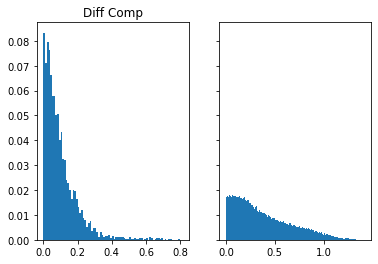

In [243]:
print(np.mean(diffComp),np.mean(sameComp))
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(sameComp,bins=np.arange(0,np.max(sameComp),0.01),weights=weightsSame,log = False)
ax1.set_title('Same Comp')
ax2.hist(diffComp,bins=np.arange(0,np.max(diffComp),0.01),weights=weightsDiff,log = False)
ax1.set_title('Diff Comp')

In [244]:
output = n.forward(g.forward(normed_adjMats_ts,node_sigs_ts))
output.shape

torch.Size([150, 5])

In [245]:
disMat = torch.cdist(output,output).flatten()
mask_same = torch.tensor(label_mat_ts - torch.diag(torch.ones(150)),dtype=bool).flatten()
mask_diff = torch.tensor(1 - label_mat_ts,dtype=bool).flatten()
sameComp = disMat[mask_same].detach().numpy()
diffComp = disMat[mask_diff].detach().numpy()
weightsSame = np.ones_like(sameComp) / len(sameComp)
weightsDiff = np.ones_like(diffComp) / len(diffComp)

/var/folders/t4/vdzymfw562g8ml8ks_2b5l5r0000gn/T/ipykernel_15013/3817663312.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_same = torch.tensor(label_mat_ts - torch.diag(torch.ones(150)),dtype=bool).flatten()
/var/folders/t4/vdzymfw562g8ml8ks_2b5l5r0000gn/T/ipykernel_15013/3817663312.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_diff = torch.tensor(1 - label_mat_ts,dtype=bool).flatten()


0.32389745 0.19046603


Text(0.5, 1.0, 'Diff Comp')

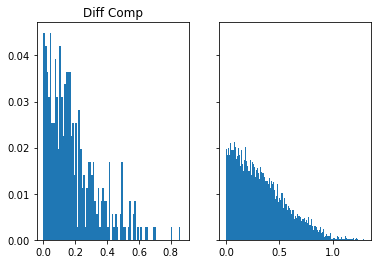

In [246]:
print(np.mean(diffComp),np.mean(sameComp))
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(sameComp,bins=np.arange(0,np.max(sameComp),0.01),weights=weightsSame,log = False)
ax1.set_title('Same Comp')
ax2.hist(diffComp,bins=np.arange(0,np.max(diffComp),0.01),weights=weightsDiff,log = False)
ax1.set_title('Diff Comp')

In [247]:
#from matplotlib.pyplot import figure
#figure(figsize=(10, 8), dpi=80)
plt.

SyntaxError: invalid syntax (556129262.py, line 3)

In [167]:
BigDiffIndices = np.where(disMat.detach().numpy().flatten() > 0.1)[0].tolist()

In [149]:
len(BigDiffIndices)

18906

In [150]:
vizMat = np.zeros([30,30])
vizMat

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0

In [152]:
for index in BigDiffIndices:
    row, col = divmod(index,150)
    cat1, cat2 = int(label_np[row]),int(label_np[col])
    #print(cat1,cat2, (cat1 == cat2))
    vizMat[cat1,cat2] += 1
    vizMat[cat2,cat1] += 1


In [153]:
vizMat = vizMat / np.max(vizMat)
vizMat

array([[0.2       , 0.22758621, 0.17586207, 0.62758621, 0.15172414,
        0.2137931 , 0.34137931, 0.37931034, 0.27586207, 0.22068966,
        0.15862069, 0.24482759, 0.36206897, 0.25517241, 0.32413793,
        0.43793103, 0.46206897, 0.1862069 , 0.25862069, 0.30344828,
        0.38275862, 0.47931034, 0.13448276, 0.49310345, 0.44482759,
        0.43103448, 0.31724138, 0.10344828, 0.1862069 , 0.21724138],
       [0.22758621, 0.1862069 , 0.13793103, 0.57931034, 0.12758621,
        0.19655172, 0.30344828, 0.29655172, 0.22068966, 0.16551724,
        0.14827586, 0.21034483, 0.29310345, 0.20689655, 0.24482759,
        0.35172414, 0.34137931, 0.15862069, 0.19655172, 0.25517241,
        0.29310345, 0.37586207, 0.10689655, 0.36896552, 0.36896552,
        0.35517241, 0.25172414, 0.0862069 , 0.18275862, 0.23103448],
       [0.17586207, 0.13793103, 0.04137931, 0.46551724, 0.05517241,
        0.10689655, 0.2       , 0.18965517, 0.11034483, 0.07586207,
        0.06206897, 0.12413793, 0.19655172, 0.

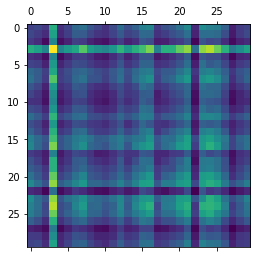

In [154]:
plt.matshow(vizMat)